<a href="https://colab.research.google.com/github/maureenwidjaja/HW0/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Acquire Training Data

In [128]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, losses
from keras.layers import TextVectorization
import re
import string
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
import nltk
from tensorflow.keras import layers, models

In [129]:
import nltk

In [138]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)

In [139]:
df.head()

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


In [140]:
def make_dataset(text, title, fake):
    """
    This function:
    - Changes the text to lowercase.
    - Removes stopwords from the article text and title.
    - Constructs a TensorFlow dataset with only title as input and fake as output.

    Args:
    - text (pd.Series): The article text.
    - title (pd.Series): The article title.
    - fake (pd.Series): The target label.

    Returns:
    - tf.data.Dataset: A TensorFlow dataset with title as input and fake as output.
    """
    # Make text lowercase
    text_new = text.str.lower()
    title_new = title.str.lower()

    # Load stopwords
    stop = stopwords.words('english')

    # Remove stopwords using list comprehension
    text_new = text_new.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
    title_new = title_new.apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

    # Create a TensorFlow dataset (Only title as input, fake as output)
    data = tf.data.Dataset.from_tensor_slices((
        {
            "title" : title_new.values,
            "text" : text_new.values
        },
        fake.values  # Output: fake column
    ))

    return data

# Validation Data

Splitting data into training and validation

In [141]:
# Apply the function to create the dataset
data = make_dataset(df['text'], df['title'], df['fake'])
data = data.shuffle(buffer_size = len(data), reshuffle_each_iteration=False)


# Split into training, validation, and test sets
total_size = len(df)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)

# Split the dataset into train, val, and test
train_data = data.take(train_size).batch(100)  # First 70% (training set)
val_data = data.skip(train_size).take(val_size).batch(100)  # Next 20% (validation set)
test_data = data.skip(train_size + val_size).batch(100)  # Remaining 10% (test set)

# Check sizes
print(f"Train size: {train_size}, Validation size: {val_size}")

Train size: 15714, Validation size: 4489


# Base Rate

In [82]:
# Create an iterator to extract labels
labels_iterator = train_data.unbatch().map(lambda inputs, label: label).as_numpy_iterator()

# Collect labels into a list
labels = list(labels_iterator)

# Count occurrences of each class
positive_count = sum(labels)  # 1 = "fake"
total_count = len(labels)

# Base rate is the max proportion of the most common label
base_rate = max(positive_count / total_count, 1 - (positive_count / total_count))

print(f"Base rate: {base_rate:.4f}")


Base rate: 0.5230


### TextVectorization

Apply Text Vectorization to Titles

In [142]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation), '')
    return no_punctuation

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,  # Only consider this many words
    output_mode='int',
    output_sequence_length=500
)

# Adapt the vectorization layer using the titles from the training data
title_vectorize_layer.adapt(train_data.map(lambda x, y: x['title']))  # Only use titles for adaptation

In [136]:
# To check the number of batches in the dataset
val_data_size = sum(1 for _ in val_data)
print("Number of batches in val_data:", val_data_size)

# If you want to check the number of elements in the dataset:
total_elements = 0
for batch in val_data:
    total_elements += batch[0].shape[0]  # Assuming batch[0] is the title (you can adjust based on the dataset structure)
print("Total number of elements in val_data:", total_elements)


Number of batches in val_data: 45
Total number of elements in val_data: 4489


In [143]:
train_data_titles = train_data.map(lambda x, y: (x['title'], y))  # Ensure 'title' is the correct key
val_data_titles = val_data.map(lambda x, y: (x['title'], y))  # Ensure 'title' is the correct key


#3. Create Models

When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?

### First model: should use only the article title as an input.

In [144]:
def model1():
    """
    Returns:
    - model: Compiled Keras model.
    """
    # Input layer for the title (text input)
    title_input = keras.Input(shape=(1,), dtype=tf.string, name="title")

    # Apply the vectorization layer to the title input
    title_vectorized = title_vectorize_layer(title_input)  # title_vectorize_layer has already been adapted

    # Embedding and layers
    x = layers.Embedding(input_dim=size_vocabulary, output_dim=32, input_length=500)(title_vectorized)
    x = layers.Dropout(0.2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Output layer — use sigmoid for binary classification
    output = layers.Dense(1, activation='sigmoid', name="output")(x)

    # Build and compile the model
    model = keras.Model(inputs=title_input, outputs=output)
    # Compile the model with both accuracy metrics
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


    return model


In [145]:
# Create the model
model_title = model1()

# Model summary
model_title.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)                   │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_9                 │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_3 (Embedding)              │ (None, 500, 32)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,145 (258.38 KB)

 Trainable params: 66,145 (258.38 KB)

 Non-trainable params: 0 (0.00 B)

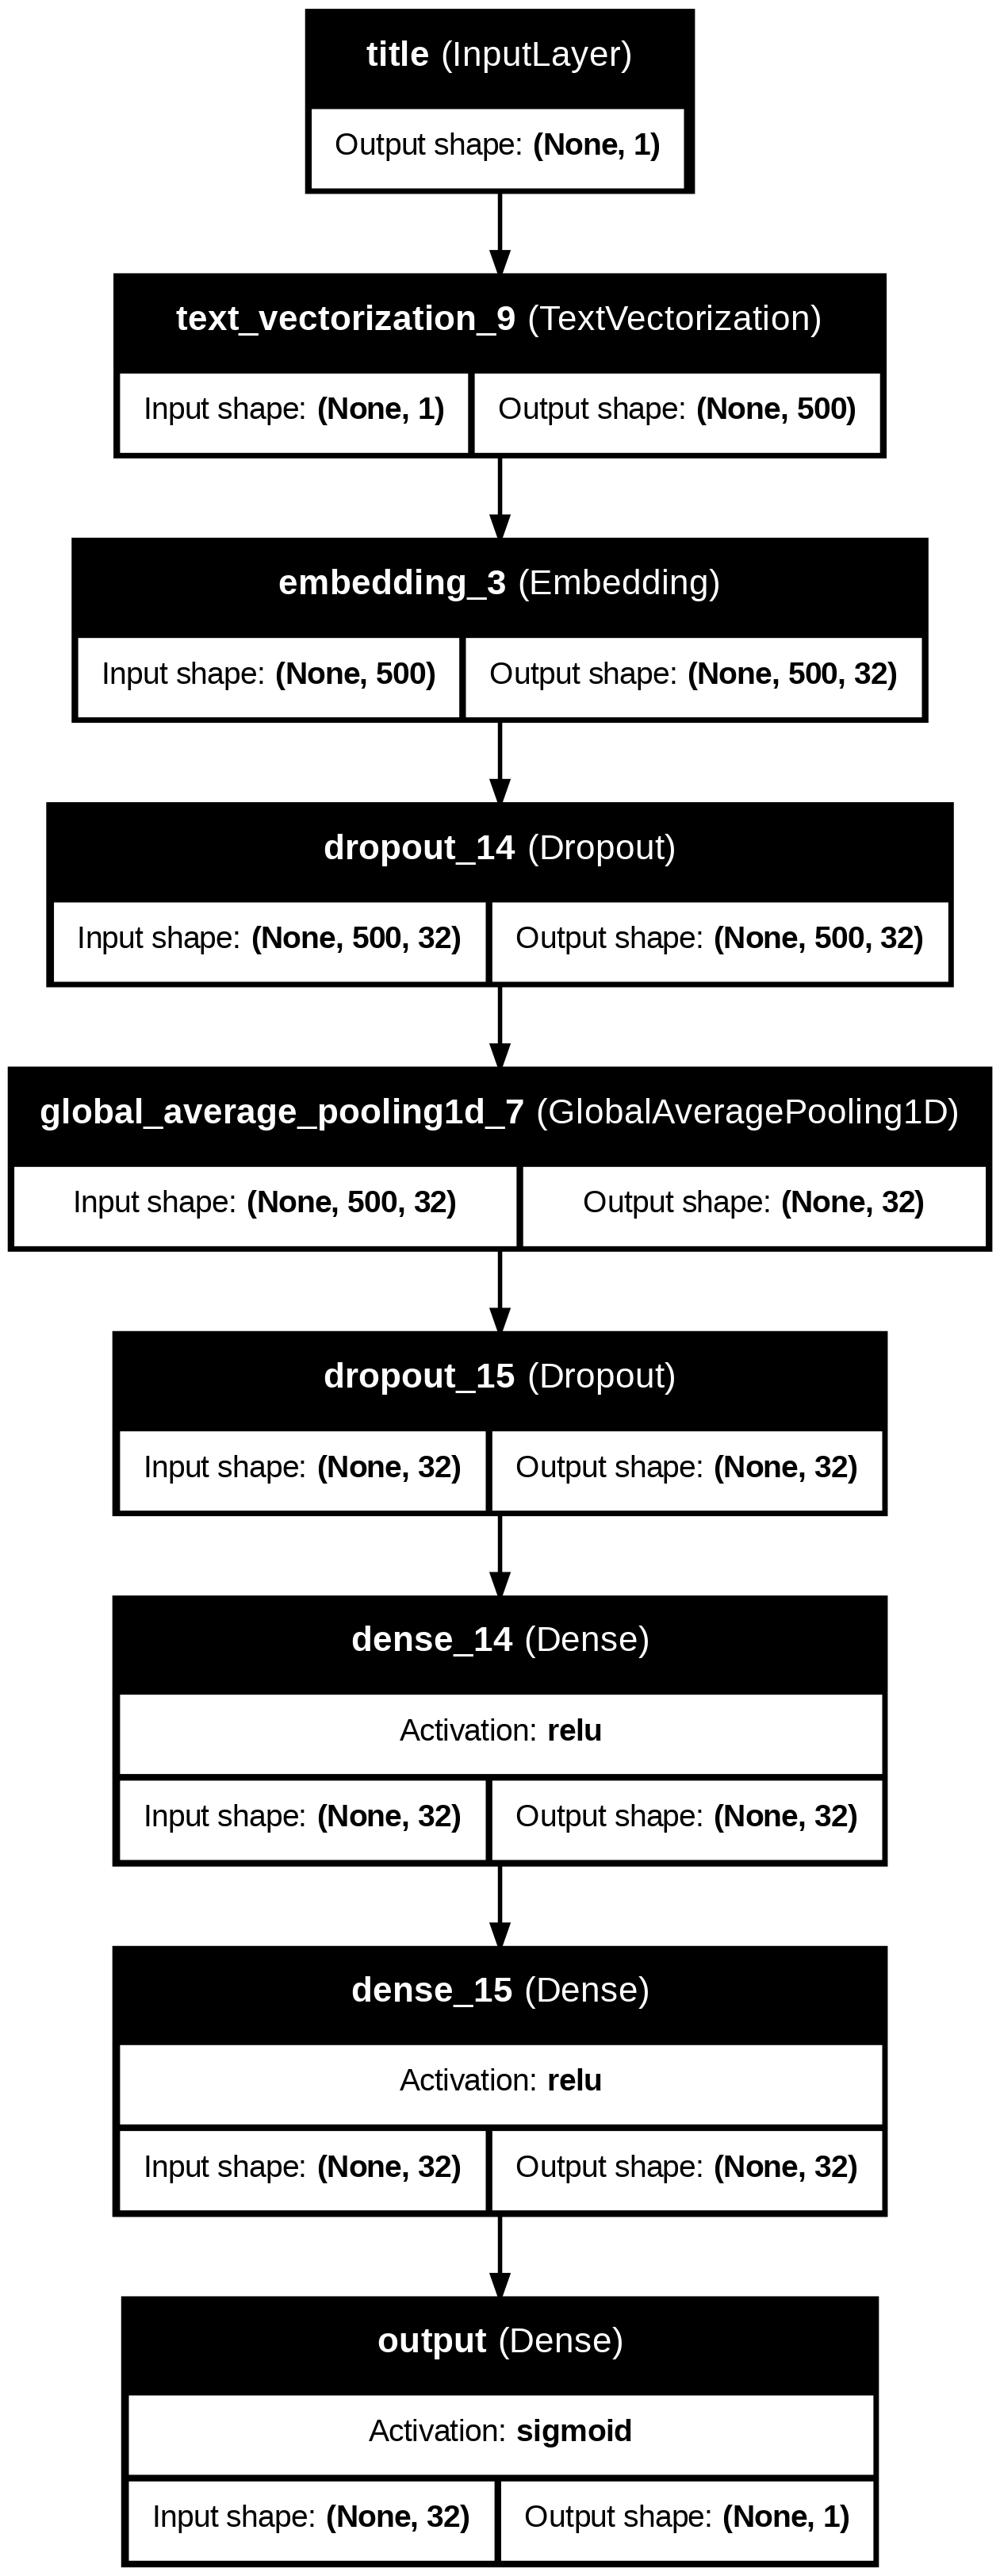

In [146]:
keras.utils.plot_model(model_title, show_shapes=True,
                       show_layer_names=True,
                       show_layer_activations=True)

In [147]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [148]:
# Train the model using only the titles as input
history_model1 = model_title.fit(
    train_data_titles,                # tf.data.Dataset containing titles and labels
    validation_data=val_data_titles,  # Validation data containing titles and labels
    epochs=20,
    callbacks=[callback],      # Early stopping callback
    verbose=True               # Show progress during training
)


Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.5134 - loss: 0.6932 - val_accuracy: 0.5337 - val_loss: 0.6922
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5174 - loss: 0.6926 - val_accuracy: 0.5337 - val_loss: 0.6901
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5292 - loss: 0.6918 - val_accuracy: 0.7563 - val_loss: 0.6874
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5463 - loss: 0.6882 - val_accuracy: 0.6719 - val_loss: 0.6729
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5780 - loss: 0.6744 - val_accuracy: 0.7690 - val_loss: 0.6042
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6725 - loss: 0.6100 - val_accuracy: 0.7561 - val_loss: 0.5379
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7378 - loss: 0.5352 - val_accuracy: 0.7799 - val_loss: 0.4726
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7586 - loss: 0.4889 - val_accuracy

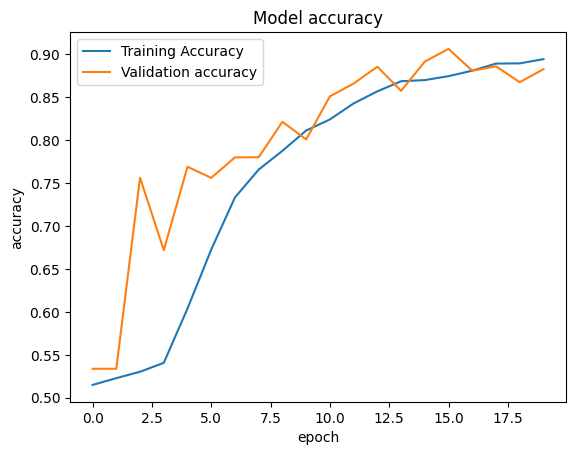

In [149]:
def visualize_hist(hist):
    plt.plot(hist.history["accuracy"], label = "Training Accuracy")
    plt.plot(hist.history["val_accuracy"], label = "Validation accuracy")
    plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
    plt.title("Model accuracy")
    plt.legend()

# Visualize the training history
visualize_hist(history_model1)


###  Second model: should use only the article text as an input.

In [151]:
# Adapt the vectorization layer using the titles from the training data
title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary,  # Only consider this many words
    output_mode='int',
    output_sequence_length=500
)
title_vectorize_layer.adapt(train_data.map(lambda x, y: x['text']))  # Only use text for adaptation

train_data_text = train_data.map(lambda x, y: (x['text'], y))  # Ensure 'title' is the correct key
val_data_text = val_data.map(lambda x, y: (x['text'], y))  # Ensure 'title' is the correct key


In [152]:
def model2():
    """
    Returns:
    - model: Compiled Keras model.
    """
    # Input layer for the title (text input)
    text_input = keras.Input(shape=(1,), dtype=tf.string, name="text")

    # Apply the vectorization layer to the title input
    text_vectorized = title_vectorize_layer(text_input)  # title_vectorize_layer has already been adapted

    # Embedding and layers
    x = layers.Embedding(input_dim=size_vocabulary, output_dim=32, input_length=500)(text_vectorized)
    x = layers.Dropout(0.2)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)

    # Output layer — use sigmoid for binary classification
    output = layers.Dense(1, activation='sigmoid', name="output")(x)

    # Build and compile the model
    model = keras.Model(inputs=text_input, outputs=output)
    # Compile the model with both accuracy metrics
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


    return model


In [153]:
# Create the model
model_text = model1()

# Model summary
model_text.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ title (InputLayer)                   │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_10                │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 500, 32)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 500, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,145 (258.38 KB)

 Trainable params: 66,145 (258.38 KB)

 Non-trainable params: 0 (0.00 B)

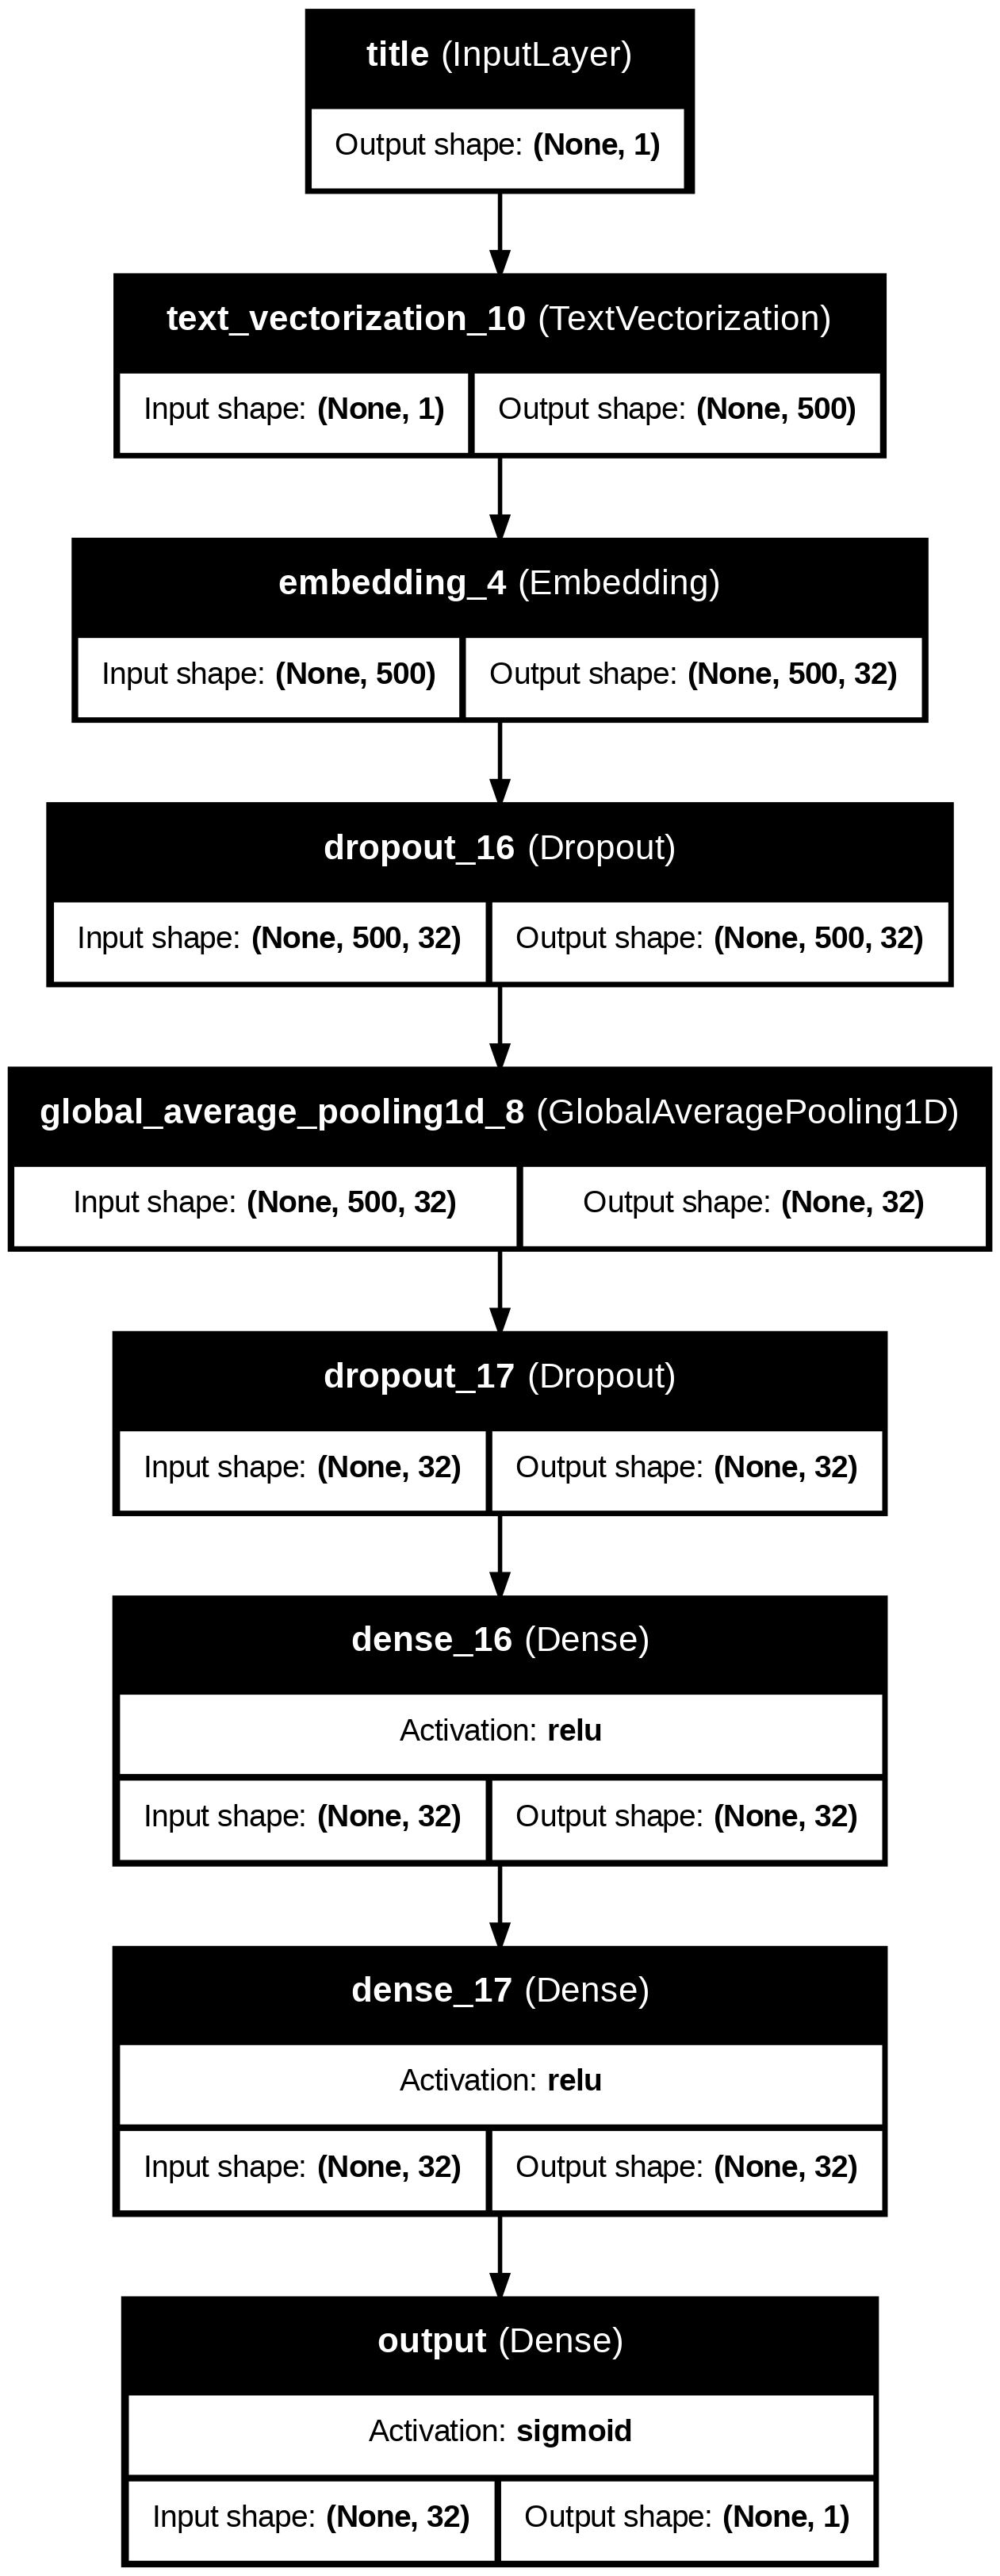

In [154]:
keras.utils.plot_model(model_text, show_shapes=True,
                       show_layer_names=True,
                       show_layer_activations=True)

In [155]:
# Train the model using only the titles as input
history_model1 = model_text.fit(
    train_data_text,                # tf.data.Dataset containing titles and labels
    validation_data=val_data_text,  # Validation data containing titles and labels
    epochs=20,
    callbacks=[callback],      # Early stopping callback
    verbose=True               # Show progress during training
)


Epoch 1/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5894 - loss: 0.6571 - val_accuracy: 0.9156 - val_loss: 0.2776
Epoch 2/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9005 - loss: 0.2547 - val_accuracy: 0.9559 - val_loss: 0.1557
Epoch 3/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9356 - loss: 0.1673 - val_accuracy: 0.9661 - val_loss: 0.1322
Epoch 4/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9439 - loss: 0.1423 - val_accuracy: 0.9483 - val_loss: 0.1287
Epoch 5/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9488 - loss: 0.1293 - val_accuracy: 0.9490 - val_loss: 0.1221
Epoch 6/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9509 - loss: 0.1285 - val_accuracy: 0.9699 - val_loss: 0.1051
Epoch 7/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9563 - loss: 0.1115 - val_accuracy: 0.9517 - val_loss: 0.1195
Epoch 8/20
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9604 - loss: 0.0992 - val_accu

###  Third model: should use both the article title and the article text as input.

In [ ]:
# here, we can see that it contains image batches and label batches.
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Two-row visualization of the dataset:
